# Phase Equilibria and Interfacial Tension of Ethanol (1) + Hexane (2) mixture

In this notebook, the calculation of a bubble point and interfacial tension of a mixture of Ethanol (1) and Hexane (2) is carried out using SAFT-VR-Mie Equation of State.

First, it is necessary to import the required packages:

- **numpy**: interface to numerical Python.
- **matplotlib**: plotting in Python.
- **SGTPy**: for fluid phase equilibria and interfacial properties computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SGTPy import component, mixture, saftvrmie
from SGTPy.equilibrium import bubblePy
from SGTPy.sgt import sgt_mix_beta0, sgt_mix

Now it is required to define pure components, this is done with the ``component`` class function. This function stores the molecular parameters, such as the number of segments (``ms``), the shape parameter (``sigma``) in Amstrong, the energy parameter (``eps``) in Kelvin units, the attractive and repulsive exponents (``lambda_a`` and ``lambda_r``). 
If the ring molecules, the ``ring`` parameter sets the geometric factor to model it correctly. If the component self-associate, the association scheme is described by the triplet ``sites=[B, P, N]`` which indicates the number of bipolar, positive and negative sites, the association energy (``eAB``) in Kelvin units and the association range and association site position  (``rcAB`` and``rdAB``, respectively) in ``sigma`` units. Finally, if the component is a polar fluid, the number of polar sites (``npol``) and the dipolar moment (``mupol``) in Debye are requires.

Additionally, the ``component`` function can store influence parameter coefficients (``cii``) in J m5 / mol2.

Components can be used to create mixtures with the ``mixture`` class function. Once a mixture has been created, more components can be added to the mixture with the ``add_component`` method, and also interaction parameters can be supplied.

In the following code block, the components ``ethanol`` and ``hexane`` are created and then a mixture is set up with them. Parameters for the Wilson activity coefficient model are set to this mixture and finally an object ``eos`` is create with the SAFT-VR-Mie EoS 

In [2]:
ethanol = component('ethanol2C', ms = 1.7728, sigma = 3.5592 , eps = 224.50,
                    lambda_r = 11.319, lambda_a = 6., eAB = 3018.05, rcAB = 0.3547,
                    rdAB = 0.4, sites = [1,0,1], cii=5.3195894757162963e-20)

hexane = component('hexane', ms = 1.96720036, sigma = 4.54762477, eps = 377.60127994, 
                   lambda_r = 18.41193194, cii = 3.6037857292110995e-19)

mix = mixture(ethanol, hexane)
kij = 0.01095218816659637
Kij = np.array([[0, kij], [kij, 0]])
mix.kij_saft(Kij)
eos = saftvrmie(mix)

The ``eos`` object includes all the necessary methods for phase equilibria and interfacial properties calculations.

The phase equilibria of a multiphase mixture is guaranteed by the following conditions:

$$	T^\alpha = T^\beta = ... = T^\pi $$ 
$$	P^\alpha = P^\beta = ... = P^\pi $$
$$	x_i^\alpha\hat{\phi}_i^\alpha = x_i^\beta \hat{\phi}_i^\beta = ... = x_i^\pi \hat{\phi}_i^\pi \quad i = 1,...,c $$ 

In phasepy and SGTPy the solution procedure will depend on the specification and the equilibria type. Available calculations are:

- ``flash``: for isobaric-isothermal two-phase flash.
- ``bubbleTy`` and ``bubblePy``: for bubble points calculations.
- ``dewTx`` and ``dewPx``: for dew points calculations.
- ``lle``: for two liquid equilibria.
- ``vlleb`` and ``vlle``: for three-phase equilibria.

In the following code block, bubble point at fixed temperature is computed with the ``bubblePy`` function. The ``full_output`` option allows obtaining all the calculation information.

In [3]:
T = 298.15 # Kelvin
X = np.array([0.37, 0.63]) # liquid molar fractions
sol = bubblePy(X, 0.21e5, X, T, eos, full_output=True)
Y, P = sol.Y, sol.P
vl, vv = sol.v1, sol.v2

# computing density vectors in mol/m3
rhol = X/vl
rhov = Y/vv

print('Computed bubble pressure: ', P)
print('Computed bubble composition: ', Y)
print('Error in bubble point calculation: ', sol.error)

Computed bubble pressure:  25912.356884605568
Computed bubble composition:  [0.25793234 0.74206766]
Error in bubble point calculation:  8.737455203799982e-12


The computed phase equilibria point is used to compute the density vector at equilibrium (``rhol``, ``rhov``). These are required to study the interfacial behavior of the mixture at the given conditions.

The density profiles at equilibrium furfill the following Euler-Lagrange problem:

$$ \sum_j c_{ij} \frac{d^2 \rho_j}{dz^2} = \mu_i - \mu_i^0 \qquad i = 1,...,c $$

$$  \rho(z \rightarrow -\infty) = \rho^\alpha \qquad \rho(z \rightarrow \infty) = \rho^\beta $$ 


In the special case when all $\beta_{ij}$ are equal to zero the system simplifies to the following algebraic system:


$$ \sqrt{c_{rr}} \left[ \mu_j(\rho) -  \mu_j^0 \right] = \sqrt{c_{jj}} \left[ \mu_r(\rho)  -  \mu_r^0 \right] \qquad j =1,...,c \neq r  $$ 

The function``sgt_mix_beta0`` is used to compute the density profiles and interfacial tension when $\beta_{ij}=0$. This function incorporates three solution methods:
- ``reference``: uses a reference component to solve the density profiles. Useful when there are no stationary points in the interface.
- ``liang``: uses Liang's path function to solve the density profiles. Useful when there are stationary points on the interface.

In [4]:
# predictive SGT, beta = 0 
bij = 0.
beta = np.array([[0, bij], [bij, 0]])
eos.beta_sgt(beta)

sol_sgtb0 = sgt_mix_beta0(rhov, rhol, T, P, eos, n=500, method='liang', full_output=True)

When at least one $\beta_{ij}$ is different to zero, the function ``sgt_mix`` must be used to solve the density profiles. This function uses orthogonal collocation to solve the Euler-Lagrande problem at a given interfacial length. This function will increase the interfacial length until the interfacial tension changes reach a given tolerance.

In [5]:
# optimized SGT, beta != 0 
bij = 0.06486106024034907
beta = np.array([[0, bij], [bij, 0]])
eos.beta_sgt(beta)

sol_sgt = sgt_mix(rhov, rhol, T, P, eos, n=30, ten_tol=0.01, full_output=True)

The interfacial tension results are shown bellow.

In [6]:
print('Computed interfacial tension beta=0: ', sol_sgtb0.tension, 'mN/m')
print('Computed interfacial tension beta=0.108: ', sol_sgt.tension, 'mN/m')

Computed interfacial tension beta=0:  16.985880532891642 mN/m
Computed interfacial tension beta=0.108:  17.157261894485828 mN/m


While the density profiles are plotted below. It can be seen that the $\beta_{ij}$ factor impacts on the computed interfacial tension as well as in the shape of the density profiles, for this mixture it corrects an adsorption-desorption phenomenon.

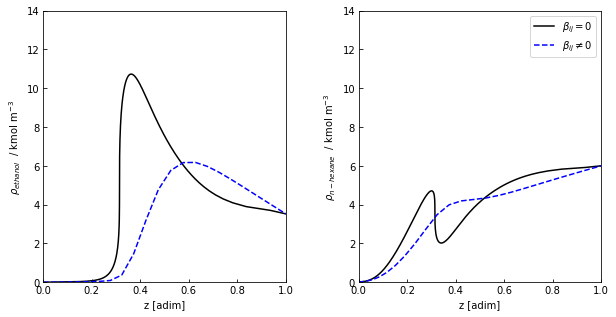

In [7]:
# reading computed density profiles
z_b0 = sol_sgtb0.z
rho_b0 = sol_sgtb0.rho / 1000 # kmol/m3

z_beta = sol_sgt.z
rho_beta = sol_sgt.rho / 1000 # kmol/m3


fig = plt.figure(figsize = (10, 5))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(z_b0/z_b0[-1], rho_b0[0], color='k')
ax2.plot(z_b0/z_b0[-1], rho_b0[1], color='k', label=r'$\beta_{ij} =0 $')

ax1.plot(z_beta/z_beta[-1], rho_beta[0], '--', color='b')
ax2.plot(z_beta/z_beta[-1], rho_beta[1], '--', color='b', label=r'$\beta_{ij} \neq 0 $')


rho_lim = 14. # kmol/m3
z_lim = 1. # dimensionless
ax1.set_xlim([0, z_lim])
ax1.set_ylim([0, rho_lim])

ax2.set_xlim([0, z_lim])
ax2.set_ylim([0, rho_lim])

ax1.set_xlabel(r'z [adim]')
ax2.set_xlabel(r'z [adim]')

ax1.set_ylabel(r'$\rho_{ethanol}$  / kmol m$^{-3}$')
ax2.set_ylabel(r'$\rho_{n-hexane}$  / kmol m$^{-3}$')

ax2.legend(loc='best')

ax1.tick_params(direction='in')
ax2.tick_params(direction='in')